## Virtual Library Clustering
The task is simple: Import the SynFerm VL, and cluster reasonably.
How to go about this?
- Import MOLs from DB

(Option A)
- 260k are too many (260,000^2 distances). Sample 10k members randomly.
- Calculate Fingerprints
- Calculate Tanimoto coefficients
- Clustering using Taylor-Butina algorithm

(Option B)
- Sample 10k members
- Calculate MACCS keys
- Dimensionality reduction with t-SNE
- Clustering using k-means algorithm

(Option C)
- MDS: No, this is to expensive

(Option D; not implemented, don't like this conceptually as it is nothing but picking the strongest outliers)
- MixMaxPicker (see https://rdkit.blogspot.com/search?q=cluster&updated-max=2020-11-18T00:36:00-08:00&max-results=20&start=1&by-date=false)


A practitioners overview for this problem:
https://www.macinchem.org/reviews/clustering/clustering.php

### Preprocessing

In [203]:
import pathlib
import sys

sys.path.append(str(pathlib.Path().resolve().parents[1]))

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from random import sample
from rdkit.Chem import MolFromSmiles
from rdkit import Chem
from rdkit.Chem import MACCSkeys, rdMolDescriptors, Draw, PandasTools
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoSimMat
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import pandas as pd
from src.definitions import DB_PATH

Import molecules from database

In [204]:

con = sqlite3.connect(DB_PATH)
cur = con.cursor()
molecule_smiles = cur.execute('SELECT smiles, id FROM virtuallibrary WHERE type = "A";').fetchall()
len(molecule_smiles)

236652

Take random (10k) sample

In [205]:

random_smi = sample(molecule_smiles, 10000)

Produce some Morgan Fingerprints

In [206]:

fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(MolFromSmiles(smi[0]),2,2048) for smi in random_smi]
len(fps)

10000

### Clustering
Try Taylor-Butina first:
(see also https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T005_compound_clustering/talktorial.ipynb)

In [207]:
def getTanimotoDistanceMatrix(fps):
    """The scipy implementation is convenient (gives array instead of 1D list), but slower than the rdkit implementation"""
    from scipy.spatial.distance import cdist

    # first generate the distance matrix:
    dists = cdist(fps, fps, metric='rogerstanimoto')
    return dists

In [208]:
def ClusterFps(fps,cutoff=0.2):
    """clustering implementation from rdkit cookbook. This takes too much memory"""
    from rdkit import DataStructs
    from rdkit.ML.Cluster import Butina

    # first generate the distance matrix:
    dists = []
    nfps = len(fps)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i],fps[:i])
        dists.extend([1-x for x in sims])
        if i % 1000 == 0:
            print(f'{i}/{len(fps)}')

    # now cluster the data:
    cs = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    return cs

In [209]:
butina_clusters = ClusterFps(fps, cutoff=0.4)

1000/10000
2000/10000
3000/10000
4000/10000
5000/10000
6000/10000
7000/10000
8000/10000
9000/10000


In [210]:
# Give a short report about the numbers of clusters and their sizes
num_clust_g1 = sum(1 for c in butina_clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in butina_clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in butina_clusters if len(c) > 25)
num_clust_g100 = sum(1 for c in butina_clusters if len(c) > 100)

print("total # clusters: ", len(butina_clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)

total # clusters:  1533
# clusters with only 1 compound:  368
# clusters with >5 compounds:  465
# clusters with >25 compounds:  68
# clusters with >100 compounds:  3


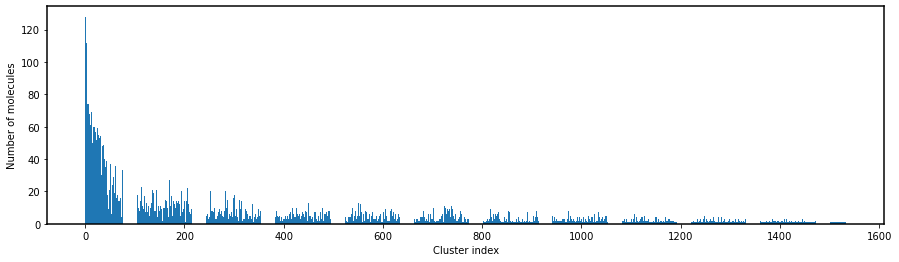

In [211]:
# Plot the size of the clusters

fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Number of molecules")
ax.bar(range(1, len(butina_clusters) + 1), [len(c) for c in butina_clusters], lw=5);

Ten molecules from largest cluster:


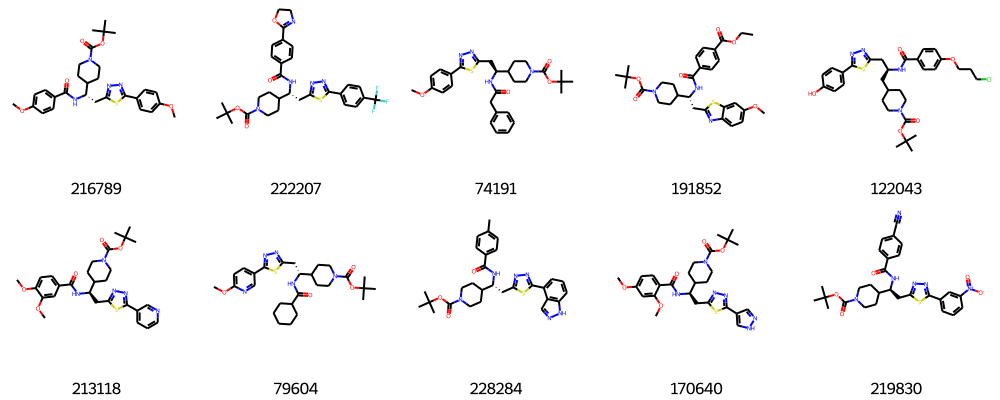

In [216]:

print("Ten molecules from largest cluster:")
Draw.MolsToGridImage(
    [MolFromSmiles(random_smi[i][0]) for i in butina_clusters[0][:10]],
    legends=[str(random_smi[i][1]) for i in butina_clusters[0][:10]],
    molsPerRow=5,
)



Centroids of the 20 largest clusters:


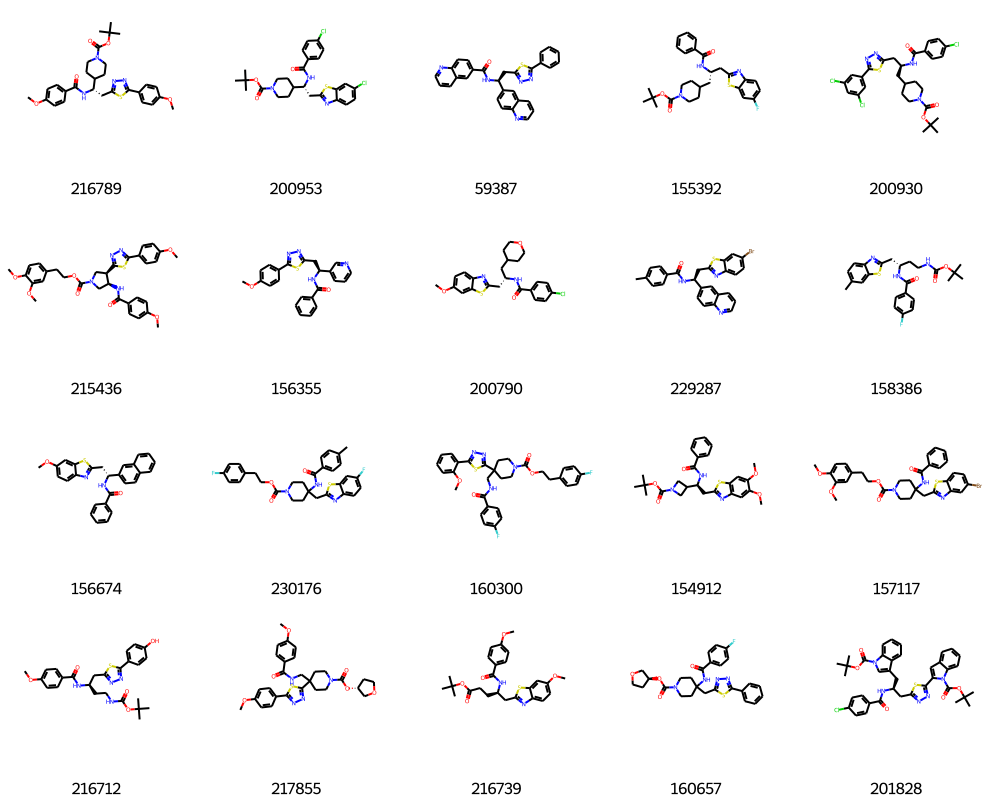

In [219]:
print("Centroids of the 20 largest clusters:")
Draw.MolsToGridImage(
    [MolFromSmiles(random_smi[i[0]][0]) for i in butina_clusters[0:20]],
     legends=[str(random_smi[i[0]][1]) for i in butina_clusters[0:20]],
    molsPerRow=5,
)

__Conclusion__: Taylor-Butina does not seem to work well. The centroids of the 20 biggest clusters are not very dissimilar. There is not even one alkyl-KAT among them

### Option B: t-SNE + k-Means

from https://chem-workflows.com/articles/2021/09/05/exploration-of-the-chemical-space-using-rdkit-and-cheminformatics/

In [220]:

PandasTools.RenderImagesInAllDataFrames(images=True)


Compute MACCS keys + Tanimoto Distance Matrix

In [221]:
mols=[Chem.MolFromSmiles(x[0]) for x in random_smi]
fps_maccs =  [MACCSkeys.GenMACCSKeys(x) for x in mols] # In this example I'll use MACCSKeys
tanimoto_sim_mat_lower_triangle=GetTanimotoSimMat(fps_maccs) # This compute a similartity matrix between all the molecules
n_mol = len(fps_maccs)
similarity_matrix = np.ones([n_mol,n_mol])
i_lower= np.tril_indices(n=n_mol,m=n_mol,k=-1)
i_upper= np.triu_indices(n=n_mol,m=n_mol,k=1)
similarity_matrix[i_lower] = tanimoto_sim_mat_lower_triangle
similarity_matrix[i_upper] = similarity_matrix.T[i_upper] 
distance_matrix = np.subtract(1,similarity_matrix) #This is the similarity matrix of all vs all molecules in our table

Dimensionality reduction with TSNE

In [222]:
TSNE_sim = TSNE(n_components=2,init='pca',random_state=90, angle = 0.3,perplexity=50).fit_transform(distance_matrix) #Remember to always tune the parameters acording your dataset!!
tsne_result = pd.DataFrame(data = TSNE_sim , columns=["TC1","TC2"]) # New table containing the tSNE results
tsne_result.head(5) #A new table containing the tSNE results

,TC1,TC2
0,-0.900282,35.185326
1,31.823011,-20.494284
2,45.764992,60.542393
3,60.592613,-36.778717
4,6.822605,-71.842644


Show tSNE embedding

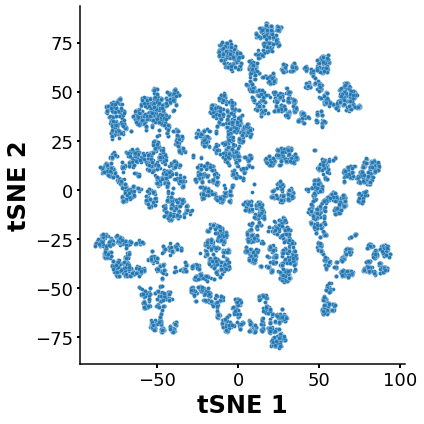

In [223]:
plt.rcParams['axes.linewidth'] = 1.5
fig, ax = plt.subplots(figsize=(6,6))

ax=sns.scatterplot(x='TC1',y='TC2',data=tsne_result,s=15,linewidth=0.2,alpha=1)
        

plt.xlabel ('tSNE 1',fontsize=24,fontweight='bold')

plt.ylabel ('tSNE 2',fontsize=24,fontweight='bold')

plt.tick_params ('both',width=2,labelsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
handles, labels = ax.get_legend_handles_labels()


plt.tight_layout()
plt.show()

It is not a priori known what the correct number of clusters (k) is in k-means. A standard method is to compute the silhouette score for different values of k. It is between 1 and -1 (higher is better) and reflects how close the cluster memebr are to their centroid as opposed to points from the other clusters

In [239]:
range_n_clusters = range(2,10, 1) # To explore the "best" number of cluster to classify our molecules
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = kmeans.fit_predict(tsne_result[['TC1','TC2']])
    silhouette_avg = silhouette_score(tsne_result[['TC1','TC1']], cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg) #This will print the silhouette score, as higher as our data is better distributed inside the clusters

For n_clusters = 2 The average silhouette_score is : 0.5633932
For n_clusters = 3 The average silhouette_score is : 0.26591906
For n_clusters = 4 The average silhouette_score is : 0.13095249
For n_clusters = 5 The average silhouette_score is : 0.050476294
For n_clusters = 6 The average silhouette_score is : 0.040157963
For n_clusters = 7 The average silhouette_score is : -0.0062610884
For n_clusters = 8 The average silhouette_score is : -0.041721724
For n_clusters = 9 The average silhouette_score is : -0.045378465


In [246]:
# define the number of clusters
k = 8

In [247]:
kmeans = KMeans(n_clusters=k, random_state=10) # We define the best number of clusters
clusters = kmeans.fit(tsne_result[['TC1','TC2']]) #TC1vs TC2

tsne_result['Cluster'] = pd.Series(clusters.labels_, index=tsne_result.index)
tsne_result.head(5) #The tSNE table now contains the number of cluster for each element

,TC1,TC2,Cluster
0,-0.900282,35.185326,4
1,31.823011,-20.494284,3
2,45.764992,60.542393,0
3,60.592613,-36.778717,7
4,6.822605,-71.842644,5


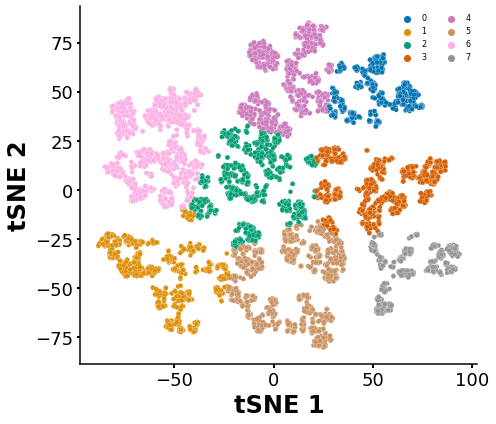

In [248]:
plt.rcParams['axes.linewidth'] = 1.5
fig, ax = plt.subplots(figsize=(7,6))

ax=sns.scatterplot(x='TC1',y='TC2',data=tsne_result, hue='Cluster',s=22,palette=sns.color_palette("colorblind", k),linewidth=0.2,alpha=1)
        

plt.xlabel ('tSNE 1',fontsize=24,fontweight='bold')

plt.ylabel ('tSNE 2',fontsize=24,fontweight='bold')

plt.tick_params ('both',width=2,labelsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles=handles[1:], labels=labels[1:])

plt.legend(loc='best',bbox_to_anchor=(1,1) ,frameon=False,prop={'size': 8},ncol=2)

plt.tight_layout()
plt.show()

In [249]:
kmeans.cluster_centers_

array([[ 50.9391   ,  49.479633 ],
       [-54.38905  , -42.281982 ],
       [-10.152756 ,   2.9260902],
       [ 52.787567 ,   1.80511  ],
       [  6.3880773,  56.256413 ],
       [  9.525951 , -48.359913 ],
       [-58.04875  ,  22.831198 ],
       [ 69.166695 , -39.560505 ]], dtype=float32)

In [250]:
from sklearn.metrics import pairwise_distances_argmin_min
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, tsne_result[['TC1','TC2']])
closest

array([4862, 8529,  191, 2915,  403, 4627, 7435, 7723])

The 8 molecules closest to their respective cluster centroid:


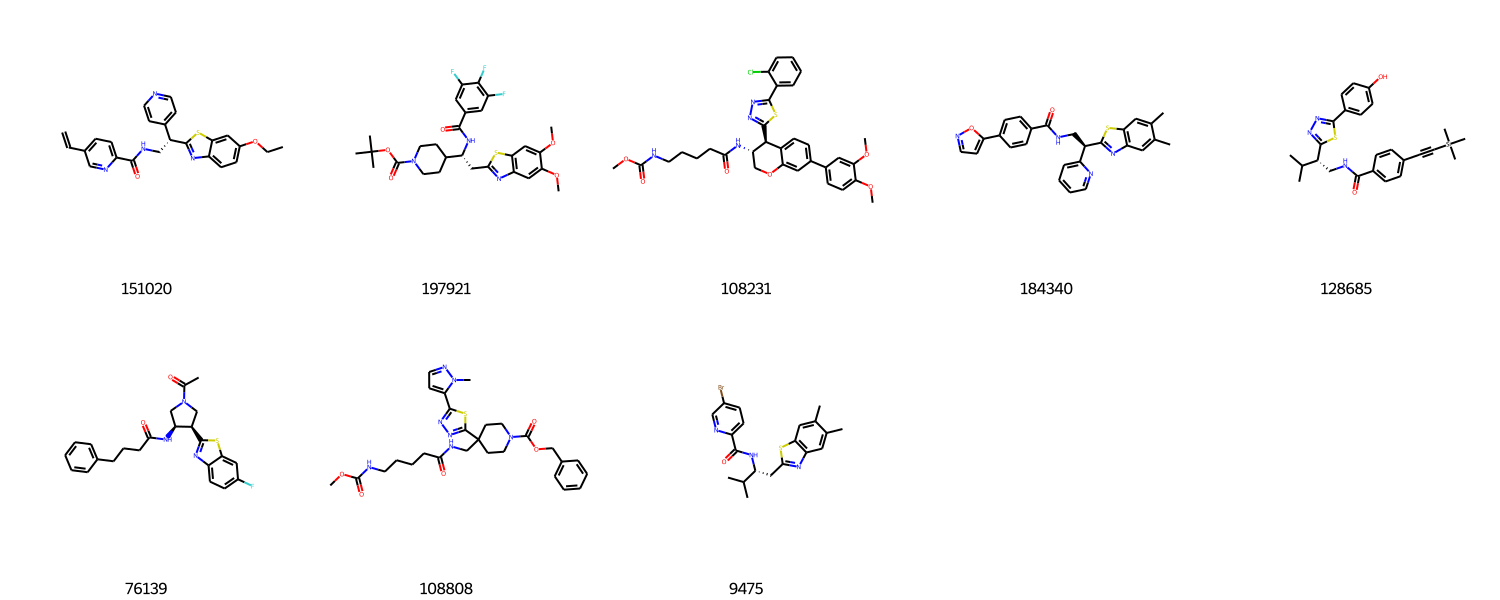

In [251]:
print(f"The {k} molecules closest to their respective cluster centroid:")
Draw.MolsToGridImage(
    [MolFromSmiles(random_smi[i][0]) for i in closest],
    legends=[str(random_smi[i][1]) for i in closest],
    molsPerRow=5,
    subImgSize=(300,300)
)



### Option C: Multi-dimensional Scaling (MDS)

In [ ]:
distances = getTanimotoDistanceMatrix(fps)
distances

In [ ]:



mds = MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=42,
                   dissimilarity="precomputed", n_jobs=-1)

pos = mds.fit(distances[:100,:100]).embedding_

__Conclusion__: MDS is too expensive to handle 10k datapoints

In [ ]:
pos